The goal of this project is to detect and classify blood cell subtypes using TensorFlow. 

### Context: 

The diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples. Automated methods to detect and classify blood cell subtypes have important medical applications.

### Dataset:

The dataset can be found [here](https://github.com/Shenggan/BCCD_Dataset) under MIT License.

The training data contains ~2500 images for each of the four blood cell subtypes, after augmentation. The validation set contains ~600 images for each subtype. The cell types are Eosinophil, Lymphocyte, Monocyte, and Neutrophil.

### Method:

Since the data set is small, we either have to use a small CNN or transfer learning, due to:

1. I only have a laptop;

2. A more complicated CNN will overfit to the data.

I will start with building a small NN from scratch in TensorFlow. I will not use Keras, because I would like to have full power of the TensorFlow.

Just for learning purpose, I will try various techniques even on this small CNN. Possible things to try:

* Pooling
* Dropout
* SeLu with Alpha dropout (from [this paper](https://arxiv.org/pdf/1706.02515.pdf))
* Bypass (Residual Network)
* Batch normalization
* Local Response Normalization
* Depthwise separable convolutional layer
* Linear bottleneck (from [MobileNetV2](https://arxiv.org/abs/1801.04381))
* More augmentation if necessary, using [tf.image](https://www.tensorflow.org/api_docs/python/tf/image) module
* ...

In [20]:
import os
from collections import defaultdict
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
plt.ion()
import gc
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
from my_util import show_graph, reset_graph

Make a list of the images.

In [3]:
data_folder = os.path.join("dataset", "blood-cells", "dataset2-master", "images")
train_folder = os.path.join(data_folder, "TRAIN")
test_folder = os.path.join(data_folder, "TEST")
cell_types = sorted([dirname for dirname in os.listdir(train_folder) 
                     if os.path.isdir(os.path.join(train_folder, dirname))])
cell_type_coding = {name : index for index, name in enumerate(cell_types)}
cell_types

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [4]:
train_images = defaultdict(list)
test_images = defaultdict(list)

for cell_type in cell_types:
    train_dir = os.path.join(train_folder, cell_type)
    test_dir = os.path.join(test_folder, cell_type)
    for filename in os.listdir(train_dir):
        if filename.endswith(".jpeg"):
            train_images[cell_type].append(os.path.join(train_dir, filename))
    for filename in os.listdir(test_dir):
        if filename.endswith(".jpeg"):
            test_images[cell_type].append(os.path.join(test_dir, filename))        

We take a look at train images:

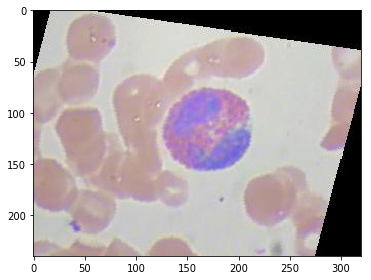

In [50]:
temp = imread('dataset\\blood-cells\\dataset2-master\\images\\TRAIN\\EOSINOPHIL\\_0_1169.jpeg')
imshow(a)

In [51]:
temp.shape

(240, 320, 3)

Cell type: EOSINOPHIL


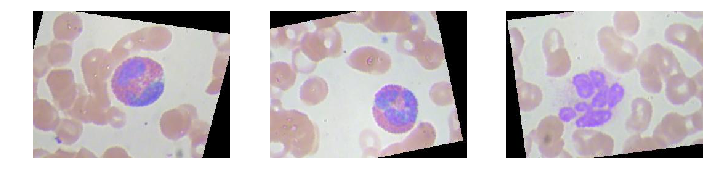

Cell type: LYMPHOCYTE


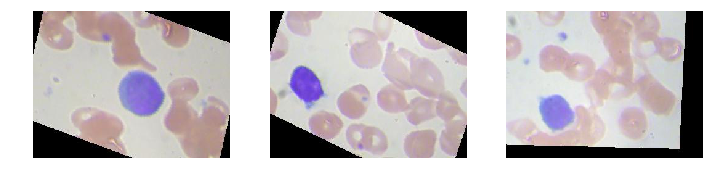

Cell type: MONOCYTE


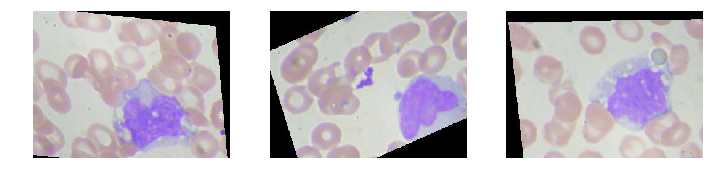

Cell type: NEUTROPHIL


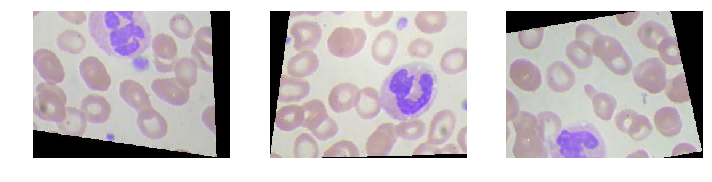

In [39]:
num = 3
for cell_type in cell_types:
    print(f"Cell type: {cell_type}")
    plt.figure(figsize=(10,5))
    for index, filepath in enumerate(train_images[cell_type][:num]):
        cell_image = imread(filepath)
        plt.subplot(100 + num * 10 + index + 1)
        imshow(cell_image)
        plt.axis("off")
    plt.show()

Read in all images into numpy arrays:

In [44]:
train_feat = []
test_feat = []
train_label = []
test_label = []

for cell, samples in train_images.items():
    for samp in samples:
        train_feat.append(imread(samp))
        train_label.append(cell_type_coding[cell])
for cell, samples in test_images.items():
    for samp in samples:
        test_feat.append(imread(samp))
        test_label.append(cell_type_coding[cell]) 

In [45]:
train_feat = np.stack(train_feat)
test_feat = np.stack(test_feat)

In [98]:
train_feat.dtype

dtype('uint8')

In [57]:
global_mean = train_feat.mean(axis = 0)
global_std = train_feat.std(axis = 0)

In [103]:
train_feat = train_feat.astype(np.float16)
test_feat = test_feat.astype(np.float16)
global_mean = global_mean.astype(np.float16)
global_std = global_std.astype(np.float16)

In [107]:
rescaled_train_feat = ((train_feat - global_mean) / global_std).astype(np.float16)
del train_feat
gc.collect()

167

In [108]:
rescaled_test_feat = ((test_feat - global_mean) / global_std).astype(np.float16)
del test_feat
gc.collect()

0

We save the normalized input to an `.npz` file. It is ~5GB.

In [123]:
np.savez_compressed(os.path.join(data_folder, 'np_data'), train_X = rescaled_train_feat, 
                    train_y = np.asarray(train_label), test_X = rescaled_test_feat, 
                    test_y = np.asarray(test_label), mean = global_mean, std = global_std)

Next time we can directly read in the numpy file.

In [8]:
with np.load(os.path.join(data_folder, 'np_data.npz')) as data:
    train_X = data["train_X"], 
    train_y = data["train_y"],
    test_X = data["test_X"],
    test_y = data["test_y"]
    global_mean = data["mean"]
    global_std = data["std"]

For some reason (probably a bug), the first three have an extra tuple layer...

In [9]:
train_X = train_X[0]
train_y = train_y[0]
test_X = test_X[0]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, global_mean.shape, global_std.shape)

(9957, 240, 320, 3) (9957,) (2487, 240, 320, 3) (2487,) (240, 320, 3) (240, 320, 3)


In [10]:
permutation = np.random.permutation(train_X.shape[0])
shuffled_train_X = train_X[permutation, :]
shuffled_train_y = train_y[permutation]
del train_X, train_y
gc.collect()

7

In [11]:
shuffled_train_X.shape

(9957, 240, 320, 3)

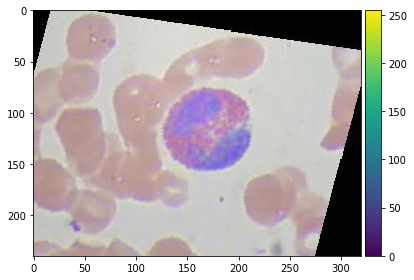

In [7]:
imshow((train_X[0, :, :, :] * global_std + global_mean).astype(int))

Now let us build a basic TensorFlow graph:

The first layer is a vanilla convolutional layer.

The second layer is a depthwise separable convolutional layer with local response normalization.

The third layer is a max pooling layer with alpha dropout. This dropout is needed because we are using SeLu. Unfortunately, TensorFlow does not have a layer interface for alpha dropout, so we need to add a customized flag for training.

The fourth layer is a fully connected layer again with alpha dropout.

The final layer is a fully connected layer outputing logits.

Some comments are in order:
* Since we are using SeLu, and the network is not very deep, batch normalization is not used.

* Since I am running on a laptop, performance is a big issue. The second layer of depthwise separable convolutional layer is particularly efficient without sacrificing too much performance. Consider a input tensor size $(w,h)$ with $f_i$ input channels and $f_o$ output channels, and filter kernel of size $(k, k)$. A traditional convolutional layer needs to compute $w\times h\times k^2\times f_i\times f_o$ times, while a depthwise separable layer with channel multiplier 2 only needs $w\times h\times f_i\times (2k^2+f_o)$ computations. 

* In fact, I tried to increase the depth and add another set of separable and max pooling layers, but that led to immediate overfitting. The training accuracy quickly went to nearly 100% while the validation accuracy did not improve significantly.

* The two dropouts help to overcome overfitting, as our training data is quite small.

In [13]:
reset_graph()
height = 240
width = 320
channels = 3
training = tf.placeholder_with_default(False, shape=(), name='training')

entire_X = tf.placeholder(shuffled_train_X.dtype, shape = (None, 240, 320, 3), name = "entire_X")
entire_y = tf.placeholder(shuffled_train_y.dtype, shape = (None), name = "entire_y")
X = tf.placeholder(tf.float32, shape = (None, 240, 320, 3), name = "X")
y = tf.placeholder(tf.int32, shape = (None), name = "y")
dataset = tf.data.Dataset.from_tensor_slices((entire_X, entire_y))
dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size = 100))
batch_size = 50
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()
with tf.name_scope("inputs"):
    next_element = iterator.get_next()

layers = []
#0 conv2d
layers.append({'channel_out' : 32, 'kernel_size' : 5, 'stride' : 2, 'name' : 'conv1', 'padding' : 'SAME'})
#1 separable conv2d + local response normalization
layers.append({'channel_out' : 64, 'kernel_size' : 3, 'stride' : 2, 'multiplier' : 2, 'name' : 'sep1', 
               'padding' : 'SAME'})
#2 maxpooling + alpha_dropout
layers.append({'kernel_size' : 3, 'stride' : 2 , 'name' : 'max1' , 'padding' : 'VALID', 'dropout' : 0.6})
#3 dense + alpha_dropout
layers.append({'channel_out' : 128, 'dropout' : 0.6, 'name' : 'full1'})
#4 dense + softmax
layers.append({'channel_out' : 4, 'name' : 'output'})

config = layers[0]
layer = tf.layers.conv2d(X, filters = config['channel_out'], kernel_size = config['kernel_size'],
                         strides = config['stride'], padding = config['padding'], activation=tf.nn.selu, 
                         name = config['name'], 
                         kernel_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'))
config = layers[1]
layer = tf.layers.separable_conv2d(layer, filters = config['channel_out'], kernel_size = config['kernel_size'],
                         strides = config['stride'], padding = config['padding'], activation=tf.nn.selu, 
                         name = config['name'], 
                         depthwise_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'),
                         pointwise_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'),
                         depth_multiplier = config['multiplier'])
with tf.name_scope(config['name']):
    layer = tf.nn.local_response_normalization(layer)
config = layers[2]
layer = tf.layers.max_pooling2d(layer, pool_size = config['kernel_size'], strides = config['stride'], 
                                padding = config['padding'], name = config['name'])
with tf.name_scope(config['name']):
    layer = tf.cond(training, lambda : tf.contrib.nn.alpha_dropout(layer, config['dropout']), 
                    lambda : tf.identity(layer))                              
config = layers[3]   
layer = tf.layers.flatten(layer, name = config['name'])
layer = tf.layers.dense(layer, config['channel_out'], activation=tf.nn.selu, name = config['name'],
                       kernel_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'))
with tf.name_scope(config['name']):
    layer = tf.cond(training, lambda : tf.contrib.nn.alpha_dropout(layer, config['dropout']), 
                    lambda : tf.identity(layer))
config = layers[4]
layer = tf.layers.flatten(layer, name = config['name'])
logits = tf.layers.dense(layer, config['channel_out'], name = config['name'],
                        kernel_initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in'))
with tf.name_scope(config['name']):
    y_prob = tf.nn.softmax(logits)
    
with tf.name_scope("train"):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("valid"):
    correct = tf.nn.in_top_k(tf.cast(logits, tf.float32), y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("util"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [15]:
np.random.seed(2018)
idx = np.random.permutation(test_X.shape[0])
subidx = np.array_split(idx, 124)
def compute_test(f):
    ave = 0
    for i in range(124):
        samp_X = test_X[subidx[i], :]
        samp_y = test_y[subidx[i]]
        ave += f.eval(feed_dict={X: samp_X, y: samp_y}) *len(subidx[i]) / len(idx)
    return ave    

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.85    

Now we train the model.

In [ ]:
batch_per_epoch = 20

best_loss = np.inf
best_accu = 0
no_progress = 0
tolerance = 500
tally = 0

with tf.Session(config=config) as sess:
    init.run()
    sess.run(iterator.initializer, feed_dict={entire_X: shuffled_train_X,
                                              entire_y: shuffled_train_y})

    while True:
        tally += 1
        if no_progress > tolerance:
            print("Early stopping!")
            break
        for iter in range(batch_per_epoch):
            batch_X, batch_y = sess.run(next_element)
            sess.run(training_op, feed_dict={X : batch_X, y : batch_y, training: True})
        train_accuracy = accuracy.eval(feed_dict={X: batch_X, y: batch_y})
        valid_accuracy = compute_test(accuracy)            
        valid_loss = compute_test(loss)
        
        print(f"Epoch {tally}, train accuracy: {train_accuracy * 100:.4f}%, valid accuracy: {valid_accuracy * 100:.4f}%, valid loss: {valid_loss:.6f}")

        if (valid_loss >= best_loss) and (valid_accuracy <= best_accu):
            no_progress += 1
        else:
            if valid_loss < best_loss:
                best_loss = valid_loss
                no_progress = 0
                best_loss_model_path = saver.save(sess, os.path.join(data_folder, "best_loss_model", "save.ckpt"))
            if valid_accuracy > best_accu:
                best_accu = valid_accuracy
                no_progress = 0
                best_accu_model_path = saver.save(sess, os.path.join(data_folder, "best_accu_model", "save.ckpt"))

    if best_accu_model_path:
        saver.restore(sess, os.path.join(data_folder, "best_accu_model", "save.ckpt"))
    valid_accuracy = compute_test(accuracy)
    print("Final best accuracy on test set:", valid_accuracy)
    if best_loss_model_path:
        saver.restore(sess, os.path.join(data_folder, "best_loss_model", "save.ckpt"))
    valid_accuracy = compute_test(accuracy)
    print("Final accuracy of best loss model on test set:", valid_accuracy)
    

Let us restore the model with best accuracy on validation set.

In [17]:
with tf.name_scope("valid2"):
    correct2 = tf.nn.in_top_k(tf.cast(logits, tf.float32), y, 2)
    accuracy2 = tf.reduce_mean(tf.cast(correct2, tf.float32))
    
with tf.name_scope("valid3"):
    correct3 = tf.nn.in_top_k(tf.cast(logits, tf.float32), y, 3)
    accuracy3 = tf.reduce_mean(tf.cast(correct3, tf.float32))

with tf.Session(config=config) as sess:
    saver.restore(sess, os.path.join(data_folder, "best_accu_model", "save.ckpt"))
    valid_accuracy = compute_test(accuracy)
    print("Final best accuracy on test set:", valid_accuracy)
    valid_accuracy = compute_test(accuracy2)
    print("Final best top 2 accuracy on test set:", valid_accuracy)
    valid_accuracy = compute_test(accuracy3)
    print("Final best top 3 accuracy on test set:", valid_accuracy)

INFO:tensorflow:Restoring parameters from dataset\blood-cells\dataset2-master\images\best_accu_model\save.ckpt
Final best accuracy on test set: 0.5987903228209865
Final best top 2 accuracy on test set: 0.806451613383909
Final best top 3 accuracy on test set: 0.9693548314033017


So the top 1, 2, 3 accuracy are around 0.6, 0.8 and 0.96. The training set reached over 90% accuracy, but much later compared to using a deeper net or less dropout, so the overfitting is alleviated. 

This is far from perfect, but still acceptable after I examined the original data closer. There are only 88, 33, 21, and 207 actual different images of each type, and the data are augmented by rotation, sheer etc., and split into train and test data probably according to origins. But the form of these cells can vary a lot, so the underlying data might lack true variations.

Another source of overfitting comes from the background. There are many other irrelevant cells in the picture, and since there are not many true samples, these will be picked up by the model.

---

It seems that the augmentation is already too excessive. Without more data, there are two possible things to try in the future:

1. Preprocess the image to filter out the background cells

2. Transfer a pretrained deep net in order to avoid overfitting to this particular dataset.